## Tweet Emotion Recognition: Natural Language Processing with TensorFlow




## Setup and Imports


In [24]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import logging
import tensorflow as tf
tf.keras.backend.clear_session()
tf.get_logger().setLevel('ERROR')

from sklearn.metrics import  confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
import pandas as pd 
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model



import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [25]:

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

## Importing, Discovering and Cleaning Data


In [26]:
data = pd.read_csv('C:/Users/sarit/Downloads/tweeter_emo.csv')

In [27]:
data = data[['text', 'emotions']].copy()

In [28]:
data.shape

(416809, 2)

In [29]:
data.drop_duplicates(inplace=True)

In [30]:
data.emotions.unique()

array(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'],
      dtype=object)

In [31]:
emotion_to_number = {'sadness': 0, 'joy': 1,'surprise':2, 'love': 3, 'anger': 4, 'fear': 5}
data['emotion_numerical'] = data['emotions'].map(emotion_to_number)


<Axes: xlabel='count', ylabel='emotions'>

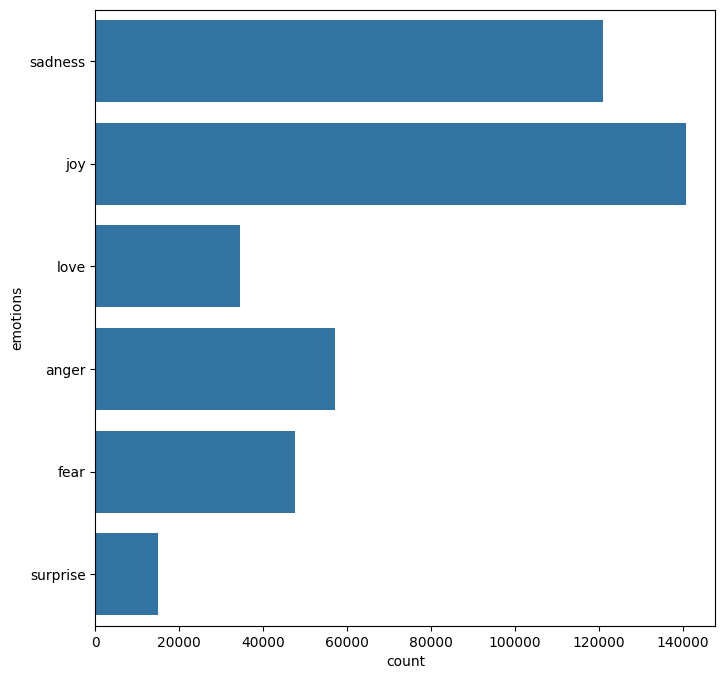

In [32]:
plt.figure(figsize=(8,8))
sns.countplot(y='emotions', data = data)

In [33]:
data['emotions'].unique()

array(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'],
      dtype=object)

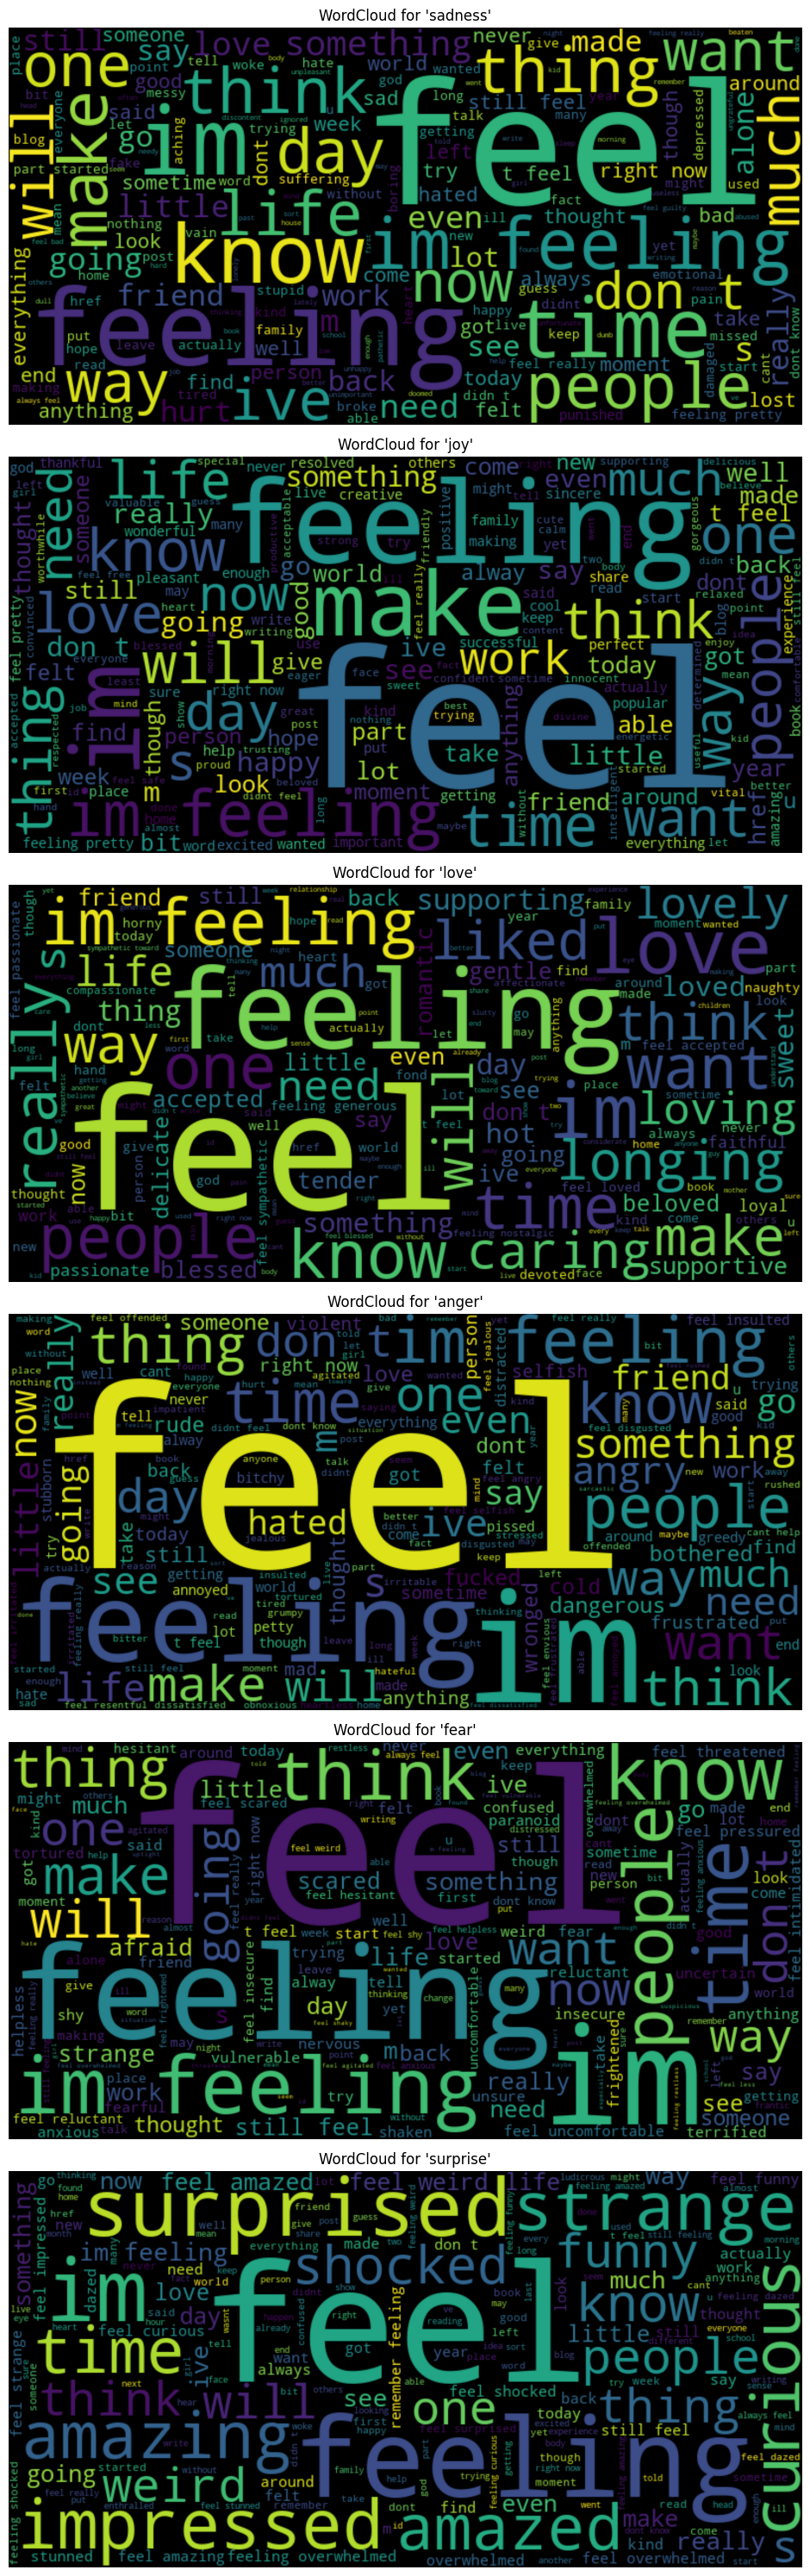

In [34]:
emotions = data.emotions.unique()
num_emotions = len(emotions)

plt.figure(figsize=(15, 5 * num_emotions))

for index, emotion in enumerate(emotions):
    wc = WordCloud(max_words=200, width=800, height=400)
    wc.generate(" ".join(data[data.emotions == emotion].text))

    plt.subplot(num_emotions, 1, index + 1)
    plt.imshow(wc, interpolation='gaussian')

    plt.title(f"WordCloud for '{emotion}'")
    plt.axis('off')

plt.tight_layout()

plt.show()

## Split data to train, text and validation

In [35]:
X = data['text'].copy()
y = data['emotion_numerical'].copy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Tokenizer

1. Tokenizing the tweets

In [36]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
val_sequences = tokenizer.texts_to_sequences(X_val)

## Padding and Truncating Sequences


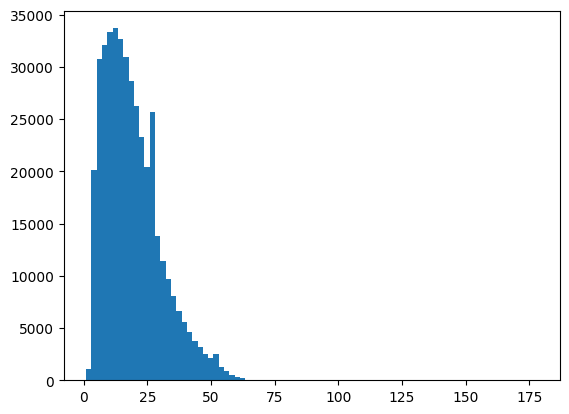

In [37]:
lengths = [len(x.split(' ')) for x in data.text]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

We notice that the majority of texts have len [15,25], and we can fix our max len to 50

In [42]:
padded_train = pad_sequences(train_sequences,maxlen = 50, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 50, truncating = 'post') 
padded_val = pad_sequences(val_sequences,maxlen = 50, truncating = 'post') 

## Creating and Training the Model


In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
checkpoint_path = "C:/Users/sarit/OneDrive/Desktop/vinayak/projects/StudyBuddy/backend/StuddyBuddy-Backend/server/studybuddy/models/training_save/model.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

model = Sequential()
model.add(Embedding(10000, output_dim = 16, input_length=50))
model.add(Bidirectional(LSTM(40, return_sequences=True)))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.summary()

In [44]:
history = model.fit(padded_train, y_train, validation_data=(padded_val, y_val), batch_size=32, epochs=16 ,callbacks=[EarlyStopping(monitor='val_accuracy', patience=3), cp_callback])

Epoch 1/16
7803/7803 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7513 - loss: 0.6447
Epoch 1: saving model to C:/Users/sarit/OneDrive/Desktop/vinayak/projects/StudyBuddy/backend/StuddyBuddy-Backend/server/studybuddy/models/training_save/model.weights.h5
7803/7803 ━━━━━━━━━━━━━━━━━━━━ 305s 38ms/step - accuracy: 0.7513 - loss: 0.6447 - val_accuracy: 0.5809 - val_loss: 1.1907
Epoch 2/16
7803/7803 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9359 - loss: 0.1150
Epoch 2: saving model to C:/Users/sarit/OneDrive/Desktop/vinayak/projects/StudyBuddy/backend/StuddyBuddy-Backend/server/studybuddy/models/training_save/model.weights.h5
7803/7803 ━━━━━━━━━━━━━━━━━━━━ 297s 38ms/step - accuracy: 0.9359 - loss: 0.1150 - val_accuracy: 0.7991 - val_loss: 0.6863
Epoch 3/16
7803/7803 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9404 - loss: 0.0948
Epoch 3: saving model to C:/Users/sarit/OneDrive/Desktop/vinayak/projects/StudyBuddy/backend/StuddyBuddy-Backend/server/studybuddy/models/training_save

## Evaluating the Model

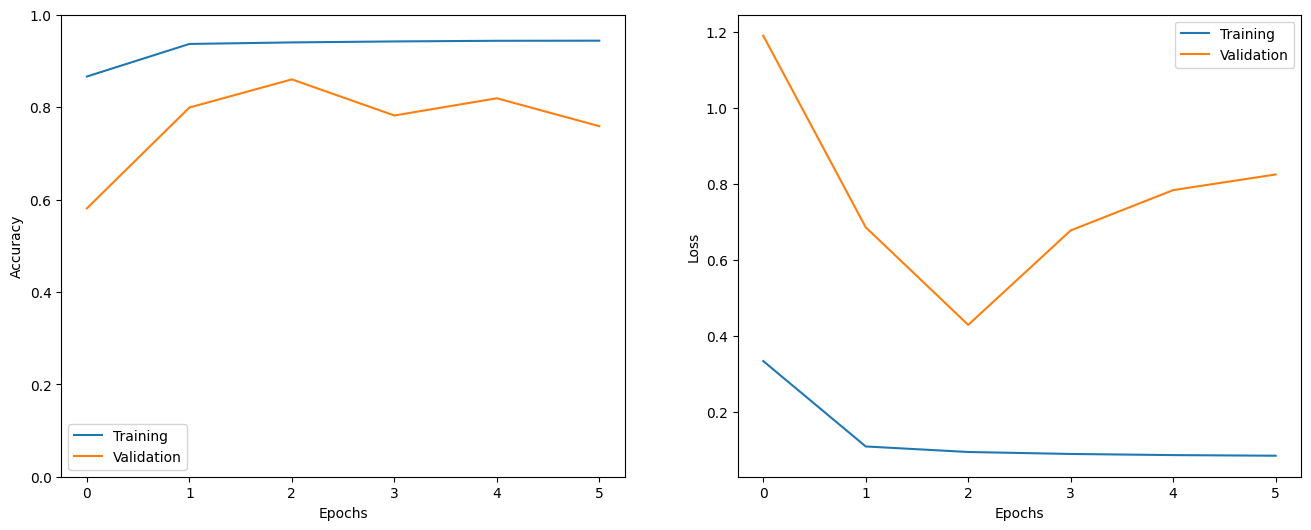

In [45]:
show_history(history)

In [46]:
loss, precision = model.evaluate(padded_test, y_test)

print(f'Test loss: {loss}')
print('Test precision: {:.2}%'.format(precision*100))

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7600 - loss: 0.8263
Test loss: 0.826570451259613
Test precision: 7.6e+01%


In [47]:
model.save('C:/Users/sarit/OneDrive/Desktop/vinayak/projects/StudyBuddy/backend/StuddyBuddy-Backend/server/studybuddy/models/tweet_emo.h5')

In [48]:
model1 = load_model('C:/Users/sarit/OneDrive/Desktop/vinayak/projects/StudyBuddy/backend/StuddyBuddy-Backend/server/studybuddy/models/tweet_emo.h5')

In [49]:
loss, precision = model1.evaluate(padded_test, y_test)

print(f'Test loss: {loss}')
print('Test precision: {:.2}'.format(precision))

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.7600 - loss: 0.8263
Test loss: 0.826570451259613
Test precision: 0.76


2601/2601 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step


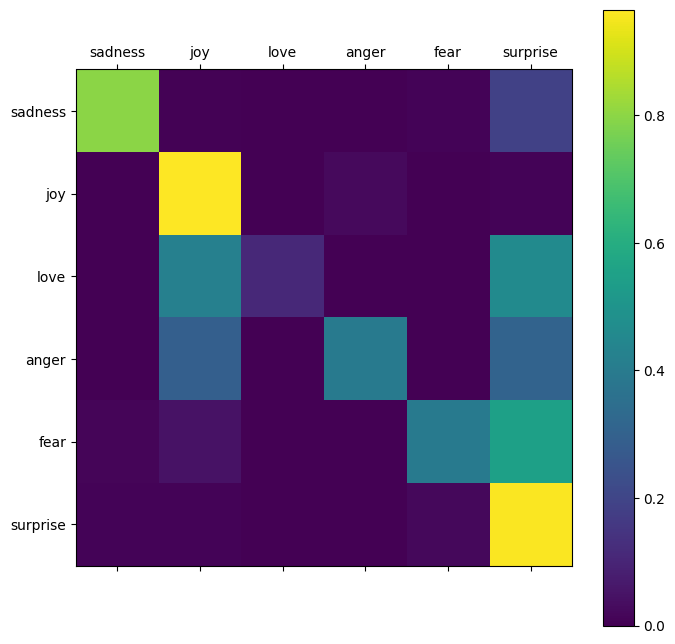

In [50]:
pred = model1.predict(padded_test)
predicted_classes = np.argmax(pred, axis=1)
show_confusion_matrix(np.asarray(y_test), predicted_classes, data.emotions.unique())


In [51]:
index_to_class=dict((v,k) for k,v in emotion_to_number.items())
i = random.randint(0, len(y_test)-1)
print(f'Tweet : {X_test.iloc[i]}')
print(f'Emotion : {index_to_class[y_test.iloc[i]]}')

i_prediction = model1.predict(np.expand_dims(padded_test[i], axis=0))[0]
predicted_class = index_to_class[np.argmax(i_prediction).astype('uint8')]

print(f'\nTweet : {X_test.iloc[i]}')
print(f'Predicted Emotion : {predicted_class}')

Tweet : i not only grew up in a nation of great wealth and opportunity in the abstract but i also grew up in an affluent neighborhood in the concrete a neighborhood where it is possible to take walks at am and feel totally carefree and unafraid
Emotion : joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

Tweet : i not only grew up in a nation of great wealth and opportunity in the abstract but i also grew up in an affluent neighborhood in the concrete a neighborhood where it is possible to take walks at am and feel totally carefree and unafraid
Predicted Emotion : joy


## Use the model to predict emotions

In [52]:
def predict_emotion(text, model):
  
  emotion_to_number = {'sadness': 0, 'joy': 1,'surprise':2, 'love': 3, 'anger': 4, 'fear': 5}
  index_to_class=dict((v,k) for k,v in emotion_to_number.items())

  padded_text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=50, padding='post', truncating='post')[0]

  prediction = model.predict(np.expand_dims(padded_text, axis=0))[0]

  predicted_class = index_to_class[np.argmax(prediction).astype('uint8')]

  return print("The emotion you feel is : ",predicted_class)


In [53]:
text = 'I feel sad, a fiery emotion that surges within me, a powerful force that demands acknowledgment'

In [54]:
predict_emotion(text, model1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
The emotion you feel is :  sadness


In [55]:
import os
import pickle
models_dir = 'C:/Users/sarit/OneDrive/Desktop/vinayak/projects/StudyBuddy/backend/StuddyBuddy-Backend/server/studybuddy/models'
os.makedirs(models_dir, exist_ok=True)
with open(os.path.join(models_dir, 'tokenizer.pickle'), 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)